# Anticipez les besoins en consommation electrique de batiments**

**Objectifs :** A fin d'atteindre l'objectif de la ville de seattle neutre en émissions de carbone en 2050 et vu que les relevés effectuer par les agents de la ville sont coûteux à obtenir, je veux tenter de **prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées en utilisant les données déjà réalisés. 


**mission:**
- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:

import warnings
warnings.filterwarnings("ignore") # éviter d'afficher les alertes pythons
pd.options.display.float_format = '{:.5f}'.format

# Chargement des données

In [3]:
filename ="2016_Building_Energy_Benchmarking.csv"
df = pd.read_csv(filename)

In [4]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00000,0659000030,...,1156514.25000,3946027.00000,12764.52930,1276453.00000,False,nan,Compliant,NaN,249.98000,2.83000
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00000,0659000220,...,950425.18750,3242851.00000,51450.81641,5145082.00000,False,nan,Compliant,NaN,295.86000,2.86000
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00000,0659000475,...,14515435.00000,49526664.00000,14938.00000,1493800.00000,False,nan,Compliant,NaN,2089.28000,2.19000
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00000,0659000640,...,811525.31250,2768924.00000,18112.13086,1811213.00000,False,nan,Compliant,NaN,286.43000,4.67000
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00000,0659000970,...,1573448.62500,5368607.00000,88039.98438,8803998.00000,False,nan,Compliant,NaN,505.01000,2.88000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

la variable 'Comments' ne contient aucune information -> supp

Je veux tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation, donc les deux variables à prédire : 

33- SiteEnergyUse(kBtu):La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.

44- TotalGHGEmissions:La quantité totale d'émissions de gaz à effet de serre.

#  Exploration et nettoyage des données

In [6]:
var_to_predict= ['TotalGHGEmissions','SiteEnergyUse(kBtu)']

In [7]:
# les colonnes numériques
numeric_col = df._get_numeric_data().columns
numeric_col

Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [8]:
# les colonnes catégorielles
categ_col = list(set(df.columns) - set(numeric_col))
categ_col

['LargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'PropertyName',
 'City',
 'SecondLargestPropertyUseType',
 'Address',
 'ComplianceStatus',
 'Outlier',
 'PrimaryPropertyType',
 'State',
 'BuildingType',
 'YearsENERGYSTARCertified',
 'ListOfAllPropertyUseTypes',
 'TaxParcelIdentificationNumber',
 'Neighborhood']

## Vérification de la présence de doublons

In [9]:
print('le nombre des lignes en doublons selon le OSEBuildingID est:',df.duplicated('OSEBuildingID').sum())

le nombre des lignes en doublons selon le OSEBuildingID est: 0


## Analyse des variable catégorielles

In [10]:
len(categ_col)

15

In [11]:
df[categ_col]

,LargestPropertyUseType,ThirdLargestPropertyUseType,PropertyName,City,SecondLargestPropertyUseType,Address,ComplianceStatus,Outlier,PrimaryPropertyType,State,BuildingType,YearsENERGYSTARCertified,ListOfAllPropertyUseTypes,TaxParcelIdentificationNumber,Neighborhood
0,Hotel,NaN,Mayflower park hotel,Seattle,NaN,405 Olive way,Compliant,NaN,Hotel,WA,NonResidential,NaN,Hotel,0659000030,DOWNTOWN
1,Hotel,Restaurant,Paramount Hotel,Seattle,Parking,724 Pine street,Compliant,NaN,Hotel,WA,NonResidential,NaN,"Hotel, Parking, Restaurant",0659000220,DOWNTOWN
2,Hotel,NaN,5673-The Westin Seattle,Seattle,NaN,1900 5th Avenue,Compliant,NaN,Hotel,WA,NonResidential,NaN,Hotel,0659000475,DOWNTOWN
3,Hotel,NaN,HOTEL MAX,Seattle,NaN,620 STEWART ST,Compliant,NaN,Hotel,WA,NonResidential,NaN,Hotel,0659000640,DOWNTOWN
4,Hotel,Swimming Pool,WARWICK SEATTLE HOTEL (ID8),Seattle,Parking,401 LENORA ST,Compliant,NaN,Hotel,WA,NonResidential,NaN,"Hotel, Parking, Swimming Pool",0659000970,DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Office,NaN,Horticulture building,Seattle,NaN,1600 S Dakota St,Error - Correct Default Data,NaN,Office,WA,Nonresidential COS,NaN,Office,1624049080,GREATER DUWAMISH
3372,Other - Recreation,NaN,International district/Chinatown CC,Seattle,NaN,719 8th Ave S,Compliant,NaN,Other,WA,Nonresidential COS,NaN,Other - Recreation,3558300000,DOWNTOWN
3373,Other - Recreation,Swimming Pool,Queen Anne Pool,Seattle,Fitness Center/Health Club/Gym,1920 1st Ave W,Compliant,NaN,Other,WA,Nonresidential COS,NaN,"Fitness Center/Health Club/Gym, Other - Recrea...",1794501150,MAGNOLIA / QUEEN ANNE
3374,Other - Recreation,Pre-school/Daycare,South Park Community Center,Seattle,Fitness Center/Health Club/Gym,8319 8th Ave S,Compliant,NaN,Mixed Use Property,WA,Nonresidential COS,NaN,"Fitness Center/Health Club/Gym, Food Service, ...",7883603155,GREATER DUWAMISH


> exploration des variables catégorielles .

In [12]:
df['City'].value_counts()

Seattle    3376
Name: City, dtype: int64

variable non utile

In [13]:
df['State'].value_counts()

WA    3376
Name: State, dtype: int64

variable non utile

In [14]:
df['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

après le traitement des valeurs manquante on pourra supprimer les lignes des biens habitable

In [15]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

In [16]:
df['ComplianceStatus'].replace('Missing Data', np.nan, inplace=True)
df['ComplianceStatus'].replace('Error - Correct Default Data', np.nan, inplace=True)

In [17]:
df['ComplianceStatus'].value_counts()

Compliant        3211
Non-Compliant      37
Name: ComplianceStatus, dtype: int64

In [18]:
df.shape

(3376, 46)

remplacer les valeurs manquantes de la variable 'ComplianceStatus' avec la valeur la plus fréquente

In [18]:
df['ComplianceStatus'] = df['ComplianceStatus'].fillna(df['ComplianceStatus'].value_counts().index[0])

In [19]:
df['ComplianceStatus'].value_counts()

Compliant        3339
Non-Compliant      37
Name: ComplianceStatus, dtype: int64

on garde que les propriétés qui ont satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours.

In [21]:
#df = df[df['ComplianceStatus'] == 'Compliant']

In [20]:
df.shape

(3376, 46)

In [21]:
df['PropertyName'].value_counts()

Northgate Plaza            3
Airport Way                2
Lakeview                   2
Crestview Apartments       2
Bayview Building           2
                          ..
1021-1045 6th Ave. S.      1
R&K Foods/RE-PC/Brinks     1
space needle               1
Mercer Court Apartments    1
The Hadley House Inc       1
Name: PropertyName, Length: 3362, dtype: int64

In [22]:
df['TaxParcelIdentificationNumber'].value_counts()

1625049001    8
3224049012    5
0925049346    5
0002400002    5
8632880000    4
             ..
8825300000    1
3876900140    1
0290900000    1
5087400030    1
4216900000    1
Name: TaxParcelIdentificationNumber, Length: 3268, dtype: int64

In [23]:
df['Neighborhood'].value_counts()

DOWNTOWN                  573
EAST                      453
MAGNOLIA / QUEEN ANNE     423
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                251
NORTHWEST                 210
SOUTHWEST                 166
NORTH                     145
BALLARD                   126
CENTRAL                   107
SOUTHEAST                  95
DELRIDGE                   80
North                      42
Central                    27
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

In [24]:
df['Neighborhood'].replace('North', 'NORTH', inplace=True)
df['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
df['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
df['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
df['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)

In [25]:
df['Neighborhood'].value_counts()

DOWNTOWN                 573
EAST                     453
MAGNOLIA / QUEEN ANNE    423
GREATER DUWAMISH         375
NORTHEAST                280
LAKE UNION               251
NORTHWEST                221
NORTH                    187
SOUTHWEST                166
CENTRAL                  134
BALLARD                  133
SOUTHEAST                 95
DELRIDGE                  85
Name: Neighborhood, dtype: int64

In [26]:
df['YearsENERGYSTARCertified'].value_counts()

2016                                    14
20172016                                 8
2017                                     7
2014                                     6
20162015                                 6
                                        ..
2016201520142013201220112010             1
2014201320122008                         1
20102008                                 1
2017201320092008                         1
201720162014201320122011201020092007     1
Name: YearsENERGYSTARCertified, Length: 65, dtype: int64

In [27]:
df['LargestPropertyUseType'].value_counts()

Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Medical Office                                            41
Supermarket/Grocery Store                                 41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
Residence Hall/Dormitory

In [28]:
df['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Restaurant                      12
Refrigerated Warehouse          12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [29]:
df['SecondLargestPropertyUseType'].value_counts()

Parking                                                 976
Office                                                  215
Retail Store                                            155
Other                                                    59
Restaurant                                               40
Non-Refrigerated Warehouse                               33
Multifamily Housing                                      18
Fitness Center/Health Club/Gym                           17
Supermarket/Grocery Store                                14
Data Center                                              13
Other - Services                                         12
Medical Office                                           11
Swimming Pool                                            10
Laboratory                                                8
Bank Branch                                               7
Distribution Center                                       7
Other - Entertainment/Public Assembly   

In [30]:
df['ThirdLargestPropertyUseType'].value_counts()

Retail Store                                            110
Office                                                  105
Parking                                                  71
Restaurant                                               56
Other                                                    49
Swimming Pool                                            29
Non-Refrigerated Warehouse                               18
Medical Office                                           17
Data Center                                              14
Multifamily Housing                                      12
Food Service                                             11
Social/Meeting Hall                                      11
Other - Restaurant/Bar                                    9
Pre-school/Daycare                                        8
Other - Entertainment/Public Assembly                     6
Bank Branch                                               6
Fitness Center/Health Club/Gym          

In [31]:
df['ListOfAllPropertyUseTypes'].value_counts()

Multifamily Housing                                                                                                                                                       866
Multifamily Housing, Parking                                                                                                                                              464
Office                                                                                                                                                                    139
K-12 School                                                                                                                                                               135
Office, Parking                                                                                                                                                           120
                                                                                                                                  

In [32]:
print('missing values mean')
df[['ListOfAllPropertyUseTypes','PrimaryPropertyType','LargestPropertyUseType','SecondLargestPropertyUseType']].isna().mean()

missing values mean


ListOfAllPropertyUseTypes      0.00267
PrimaryPropertyType            0.00000
LargestPropertyUseType         0.00592
SecondLargestPropertyUseType   0.50267
dtype: float64

imputation des valeurs manquantes de la variable ListOfAllPropertyUseTypes à partir de la variable :PrimaryPropertyType.

In [33]:
df.ListOfAllPropertyUseTypes.fillna(df.PrimaryPropertyType, inplace=True)

In [34]:
df.SecondLargestPropertyUseType.fillna('Missing',inplace=True)

In [35]:
df.LargestPropertyUseType.fillna('Missing',inplace=True)

In [36]:
df[['ListOfAllPropertyUseTypes','PrimaryPropertyType','LargestPropertyUseType','SecondLargestPropertyUseType']].isna().mean()

ListOfAllPropertyUseTypes      0.00000
PrimaryPropertyType            0.00000
LargestPropertyUseType         0.00000
SecondLargestPropertyUseType   0.00000
dtype: float64

In [37]:
df['Address'].value_counts()

2600 SW Barton St              4
2203 Airport Way S             4
309 South Cloverdale Street    4
2600 SW Holden St              2
1100 Olive Way                 2
                              ..
1563 6th Ave S                 1
1020 1st Ave S                 1
2905 1st Ave                   1
2760 nw 85                     1
4020 AURORA AVE N              1
Name: Address, Length: 3354, dtype: int64

## Traitement des outliers

In [38]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [39]:
df[~df['Outlier'].isna()].describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,...,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,32.00000,0.00000,32.00000,32.00000
mean,23372.37500,2016.00000,98113.28125,3.84375,47.60489,-122.34043,1950.53125,1.15625,4.06250,53753.56250,...,4239594.43977,4339861.56177,272018.62500,868720.03363,2964072.75000,7146.24599,714624.59375,nan,79.61313,1.27531
std,11554.17922,0.00000,10.67476,2.37065,0.03751,0.02788,37.15094,0.72332,4.03163,43188.45247,...,8869576.82990,8956810.86640,1538769.71477,2430096.70897,8291490.01991,19106.92459,1910692.48904,nan,164.80722,2.56128
min,350.00000,2016.00000,98101.00000,1.00000,47.51709,-122.40147,1900.00000,1.00000,1.00000,20039.00000,...,13409.00000,13409.00000,0.00000,3332.50000,11370.00000,0.00000,0.00000,nan,0.09000,0.00000
25%,20554.50000,2016.00000,98104.00000,2.00000,47.58276,-122.35379,1910.00000,1.00000,2.00000,26058.25000,...,136151.69727,144824.72267,0.00000,30407.97559,103752.00000,0.00000,0.00000,nan,1.11000,0.04000
50%,24229.50000,2016.00000,98110.50000,3.00000,47.60798,-122.33525,1955.50000,1.00000,3.00000,39556.00000,...,270414.25780,292313.00000,0.00000,65457.79883,223342.00000,0.00000,0.00000,nan,5.06000,0.14000
75%,26890.75000,2016.00000,98122.00000,7.00000,47.62139,-122.32220,1982.50000,1.00000,4.00000,51750.00000,...,4540034.62500,4731598.37500,0.00000,482337.42188,1645735.00000,2061.51968,206152.00000,nan,60.28500,1.49500
max,50071.00000,2016.00000,98134.00000,7.00000,47.70188,-122.27880,2015.00000,5.00000,24.00000,172842.00000,...,41399504.00000,41650404.00000,8704596.00000,11663150.00000,39794668.00000,94960.35938,9496036.00000,nan,686.53000,11.38000


In [40]:
df[df['Outlier'].isna()].describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3344.00000,3344.00000,3328.00000,3344.00000,3344.00000,3344.00000,3344.00000,3336.00000,3344.00000,3344.00000,...,3339.00000,3338.00000,3335.00000,3335.00000,3335.00000,3335.00000,3335.00000,0.00000,3335.00000,3335.00000
mean,21188.28888,2016.00000,98116.98438,4.44498,47.62422,-122.33474,1968.74581,1.10641,4.71531,95226.64713,...,5414823.42851,5285707.03641,274620.62767,1088729.94284,3714746.57274,13747.78648,1374778.65189,nan,120.10884,1.17496
std,12229.77276,0.00000,18.67261,2.11768,0.04781,0.02720,33.00548,2.11734,5.50666,219806.06672,...,21696835.46636,15991475.87997,3928101.82225,4366981.26692,14900140.07339,67390.79107,6739079.11255,nan,541.16424,1.81340
min,1.00000,2016.00000,98006.00000,1.00000,47.49917,-122.41425,1900.00000,0.00000,0.00000,11285.00000,...,0.00000,0.00000,0.00000,-33826.80078,-115417.00000,0.00000,0.00000,nan,-0.80000,-0.02000
25%,19989.50000,2016.00000,98105.00000,3.00000,47.60018,-122.35055,1948.75000,1.00000,2.00000,28523.25000,...,935188.78125,983237.89062,0.00000,188771.79690,644089.50000,0.00000,0.00000,nan,9.65500,0.21000
50%,23108.50000,2016.00000,98115.00000,4.00000,47.61888,-122.33248,1975.00000,1.00000,4.00000,44291.00000,...,1809101.50000,1914797.00000,0.00000,346729.81250,1183042.00000,3294.02173,329402.00000,nan,34.11000,0.62000
75%,25992.50000,2016.00000,98122.00000,7.00000,47.65729,-122.31934,1997.00000,1.00000,5.00000,91150.75000,...,4218830.50000,4379956.50000,0.00000,831021.78125,2835446.00000,11932.13330,1193213.50000,nan,94.01500,1.37000
max,50226.00000,2016.00000,98272.00000,7.00000,47.73387,-122.22097,2015.00000,111.00000,99.00000,9320156.00000,...,873923712.00000,471613856.00000,134943456.00000,192577488.00000,657074389.00000,2979090.00000,297909000.00000,nan,16870.98000,34.09000


on supprime les lignes où les valeurs des outilers est (low or high outliers)

In [41]:
df.drop(df.dropna(subset = ['Outlier']).index, inplace = True)

In [42]:
df[['Outlier']].isna().mean()

Outlier   1.00000
dtype: float64

> Vérifier la présence d'outliers pour les deux variables 'TotalGHGEmissions','SiteEnergyUse(kBtu)'

In [43]:
var_to_predict

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

In [44]:
df[var_to_predict].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,3335.00000,3339.00000
mean,120.10884,5414823.42851
std,541.16424,21696835.46636
min,-0.80000,0.00000
25%,9.65500,935188.78125
50%,34.11000,1809101.50000
75%,94.01500,4218830.50000
max,16870.98000,873923712.00000


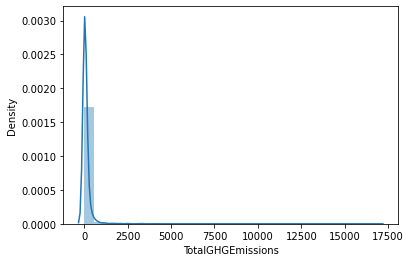

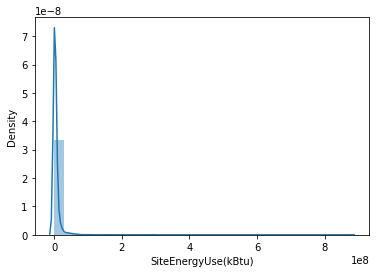

In [45]:
for column in var_to_predict:
    sns.distplot(df[column], bins=30)
    plt.show()

In [46]:
df.shape

(3344, 46)

In [47]:
df[var_to_predict].isna().mean()

TotalGHGEmissions     0.00269
SiteEnergyUse(kBtu)   0.00150
dtype: float64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3344 non-null   int64  
 1   DataYear                         3344 non-null   int64  
 2   BuildingType                     3344 non-null   object 
 3   PrimaryPropertyType              3344 non-null   object 
 4   PropertyName                     3344 non-null   object 
 5   Address                          3344 non-null   object 
 6   City                             3344 non-null   object 
 7   State                            3344 non-null   object 
 8   ZipCode                          3328 non-null   float64
 9   TaxParcelIdentificationNumber    3344 non-null   object 
 10  CouncilDistrictCode              3344 non-null   int64  
 11  Neighborhood                     3344 non-null   object 
 12  Latitude            

In [49]:
numeric_col = df._get_numeric_data().columns

In [50]:
numeric_col

Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [51]:
df[var_to_predict].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,3335.00000,3339.00000
mean,120.10884,5414823.42851
std,541.16424,21696835.46636
min,-0.80000,0.00000
25%,9.65500,935188.78125
50%,34.11000,1809101.50000
75%,94.01500,4218830.50000
max,16870.98000,873923712.00000


In [52]:
for column in var_to_predict:
    "outliers aux extrémités des distributions"
    df.loc[df[column] > df[column].quantile(0.995), column] = np.nan
    df.loc[df[column] < df[column].quantile(0.005), column] = np.nan
    #df.loc[df[column] < 0, column] = np.nan
df[numeric_col].isna().mean()
df[var_to_predict].isna().mean()
df[var_to_predict].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,3301.00000,3322.00000
mean,91.01638,4357712.12396
std,173.72778,7720143.58260
min,0.86000,0.00000
25%,9.73000,932082.46875
50%,34.11000,1799533.43750
75%,93.23000,4167016.87500
max,2055.82000,72587024.00000


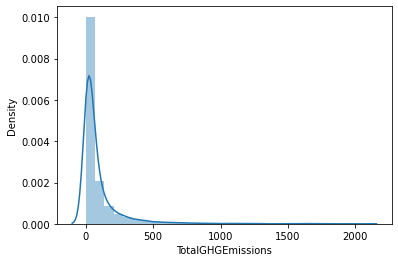

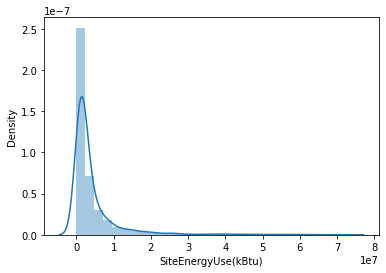

In [53]:
for column in var_to_predict:
    sns.distplot(df[column], bins=30)
    plt.show()

In [54]:
df[var_to_predict].isna().mean()

TotalGHGEmissions     0.01286
SiteEnergyUse(kBtu)   0.00658
dtype: float64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3344 non-null   int64  
 1   DataYear                         3344 non-null   int64  
 2   BuildingType                     3344 non-null   object 
 3   PrimaryPropertyType              3344 non-null   object 
 4   PropertyName                     3344 non-null   object 
 5   Address                          3344 non-null   object 
 6   City                             3344 non-null   object 
 7   State                            3344 non-null   object 
 8   ZipCode                          3328 non-null   float64
 9   TaxParcelIdentificationNumber    3344 non-null   object 
 10  CouncilDistrictCode              3344 non-null   int64  
 11  Neighborhood                     3344 non-null   object 
 12  Latitude            

In [56]:
df[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].head()

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu)
0,7226362.50000,7456910.00000
1,8387933.00000,8664479.00000
2,72587024.00000,73937112.00000
3,6794584.00000,6946800.50000
4,14172606.00000,14656503.00000


In [57]:
df[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].isna().mean()

SiteEnergyUse(kBtu)     0.00658
SiteEnergyUseWN(kBtu)   0.00179
dtype: float64

on va imputer les valeurs manquantes de la variable 'SiteEnergyUse(kBtu)' à partir de la variable 'SiteEnergyUseWN(kBtu)'

In [58]:
df['SiteEnergyUse(kBtu)'].fillna(df['SiteEnergyUseWN(kBtu)'], inplace=True)

In [59]:
df[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].isna().mean()

SiteEnergyUse(kBtu)     0.00150
SiteEnergyUseWN(kBtu)   0.00179
dtype: float64

On va imputer les valeurs manquantes de la variable à prédire 'TotalGHGEmissions'  et le restes des valeurs manquantes de 'SiteEnergyUse(kBtu)'avec la mediane

In [60]:
medianTotalGHGEmissions = df['TotalGHGEmissions'].median()
# Remplacer les valeurs manquantes par la médiane pour les variables numérique
df['TotalGHGEmissions'] = df['TotalGHGEmissions'].fillna(value = medianTotalGHGEmissions)

In [61]:
medianSiteEnergyUse = df['SiteEnergyUse(kBtu)'].median()
# Remplacer les valeurs manquantes par la médiane pour les variables numériquemedianSiteEnergyUse
df['SiteEnergyUse(kBtu)'] = df['SiteEnergyUse(kBtu)'].fillna(value = medianSiteEnergyUse)

In [62]:
df[var_to_predict].isna().mean()

TotalGHGEmissions     0.00000
SiteEnergyUse(kBtu)   0.00000
dtype: float64

In [63]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3344.00000,3344.00000,3328.00000,3344.00000,3344.00000,3344.00000,3344.00000,3336.00000,3344.00000,3344.00000,...,3344.00000,3338.00000,3335.00000,3335.00000,3335.00000,3335.00000,3335.00000,0.00000,3344.00000,3335.00000
mean,21188.28888,2016.00000,98116.98438,4.44498,47.62422,-122.33474,1968.74581,1.10641,4.71531,95226.64713,...,5168407.80702,5285707.03641,274620.62767,1088729.94284,3714746.57274,13747.78648,1374778.65189,nan,90.28463,1.17496
std,12229.77276,0.00000,18.67261,2.11768,0.04781,0.02720,33.00548,2.11734,5.50666,219806.06672,...,15965747.79557,15991475.87997,3928101.82225,4366981.26692,14900140.07339,67390.79107,6739079.11255,nan,172.72593,1.81340
min,1.00000,2016.00000,98006.00000,1.00000,47.49917,-122.41425,1900.00000,0.00000,0.00000,11285.00000,...,0.00000,0.00000,0.00000,-33826.80078,-115417.00000,0.00000,0.00000,nan,0.86000,-0.02000
25%,19989.50000,2016.00000,98105.00000,3.00000,47.60018,-122.35055,1948.75000,1.00000,2.00000,28523.25000,...,935292.73438,983237.89062,0.00000,188771.79690,644089.50000,0.00000,0.00000,nan,9.92750,0.21000
50%,23108.50000,2016.00000,98115.00000,4.00000,47.61888,-122.33248,1975.00000,1.00000,4.00000,44291.00000,...,1808401.37500,1914797.00000,0.00000,346729.81250,1183042.00000,3294.02173,329402.00000,nan,34.11000,0.62000
75%,25992.50000,2016.00000,98122.00000,7.00000,47.65729,-122.31934,1997.00000,1.00000,5.00000,91150.75000,...,4216153.50000,4379956.50000,0.00000,831021.78125,2835446.00000,11932.13330,1193213.50000,nan,91.57000,1.37000
max,50226.00000,2016.00000,98272.00000,7.00000,47.73387,-122.22097,2015.00000,111.00000,99.00000,9320156.00000,...,471613856.00000,471613856.00000,134943456.00000,192577488.00000,657074389.00000,2979090.00000,297909000.00000,nan,2055.82000,34.09000


In [64]:
df.isna().mean()

OSEBuildingID                     0.00000
DataYear                          0.00000
BuildingType                      0.00000
PrimaryPropertyType               0.00000
PropertyName                      0.00000
Address                           0.00000
City                              0.00000
State                             0.00000
ZipCode                           0.00478
TaxParcelIdentificationNumber     0.00000
CouncilDistrictCode               0.00000
Neighborhood                      0.00000
Latitude                          0.00000
Longitude                         0.00000
YearBuilt                         0.00000
NumberofBuildings                 0.00239
NumberofFloors                    0.00000
PropertyGFATotal                  0.00000
PropertyGFAParking                0.00000
PropertyGFABuilding(s)            0.00000
ListOfAllPropertyUseTypes         0.00000
LargestPropertyUseType            0.00000
LargestPropertyUseTypeGFA         0.00598
SecondLargestPropertyUseType      

In [65]:
numeric_col

Index(['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

## Traitement des valeurs manquantes

In [66]:
df[numeric_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 0 to 3375
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3344 non-null   int64  
 1   DataYear                         3344 non-null   int64  
 2   ZipCode                          3328 non-null   float64
 3   CouncilDistrictCode              3344 non-null   int64  
 4   Latitude                         3344 non-null   float64
 5   Longitude                        3344 non-null   float64
 6   YearBuilt                        3344 non-null   int64  
 7   NumberofBuildings                3336 non-null   float64
 8   NumberofFloors                   3344 non-null   int64  
 9   PropertyGFATotal                 3344 non-null   int64  
 10  PropertyGFAParking               3344 non-null   int64  
 11  PropertyGFABuilding(s)           3344 non-null   int64  
 12  LargestPropertyUseTy

In [67]:
index = df[df['SiteEnergyUse(kBtu)']==0].index

In [68]:
df = df.drop(index)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3325 non-null   int64  
 1   DataYear                         3325 non-null   int64  
 2   BuildingType                     3325 non-null   object 
 3   PrimaryPropertyType              3325 non-null   object 
 4   PropertyName                     3325 non-null   object 
 5   Address                          3325 non-null   object 
 6   City                             3325 non-null   object 
 7   State                            3325 non-null   object 
 8   ZipCode                          3309 non-null   float64
 9   TaxParcelIdentificationNumber    3325 non-null   object 
 10  CouncilDistrictCode              3325 non-null   int64  
 11  Neighborhood                     3325 non-null   object 
 12  Latitude            

In [70]:
df[df.TotalGHGEmissions==0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


In [71]:
df[numeric_col].isna().mean()

OSEBuildingID                     0.00000
DataYear                          0.00000
ZipCode                           0.00481
CouncilDistrictCode               0.00000
Latitude                          0.00000
Longitude                         0.00000
YearBuilt                         0.00000
NumberofBuildings                 0.00241
NumberofFloors                    0.00000
PropertyGFATotal                  0.00000
PropertyGFAParking                0.00000
PropertyGFABuilding(s)            0.00000
LargestPropertyUseTypeGFA         0.00602
SecondLargestPropertyUseTypeGFA   0.50045
ThirdLargestPropertyUseTypeGFA    0.82286
ENERGYSTARScore                   0.24541
SiteEUI(kBtu/sf)                  0.00150
SiteEUIWN(kBtu/sf)                0.00180
SourceEUI(kBtu/sf)                0.00271
SourceEUIWN(kBtu/sf)              0.00271
SiteEnergyUse(kBtu)               0.00000
SiteEnergyUseWN(kBtu)             0.00180
SteamUse(kBtu)                    0.00271
Electricity(kWh)                  

In [74]:
'''for col in numeric_col:
    median = df[col].median()
    # Remplacer les valeurs manquantes par la médiane pour les variables numérique
    df[col] = df[col].fillna(value = median)'''

'for col in numeric_col:\n    median = df[col].median()\n    # Remplacer les valeurs manquantes par la médiane pour les variables numérique\n    df[col] = df[col].fillna(value = median)'

In [72]:
df[numeric_col].isna().mean()

OSEBuildingID                     0.00000
DataYear                          0.00000
ZipCode                           0.00481
CouncilDistrictCode               0.00000
Latitude                          0.00000
Longitude                         0.00000
YearBuilt                         0.00000
NumberofBuildings                 0.00241
NumberofFloors                    0.00000
PropertyGFATotal                  0.00000
PropertyGFAParking                0.00000
PropertyGFABuilding(s)            0.00000
LargestPropertyUseTypeGFA         0.00602
SecondLargestPropertyUseTypeGFA   0.50045
ThirdLargestPropertyUseTypeGFA    0.82286
ENERGYSTARScore                   0.24541
SiteEUI(kBtu/sf)                  0.00150
SiteEUIWN(kBtu/sf)                0.00180
SourceEUI(kBtu/sf)                0.00271
SourceEUIWN(kBtu/sf)              0.00271
SiteEnergyUse(kBtu)               0.00000
SiteEnergyUseWN(kBtu)             0.00180
SteamUse(kBtu)                    0.00271
Electricity(kWh)                  

# Analyse bi-variée

In [73]:
var_to_predict

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

 influence de l'âge du bâtiment sur la consommation

Text(0.5, 1.0, "L'influance de l'age de batiment sur la consommation")

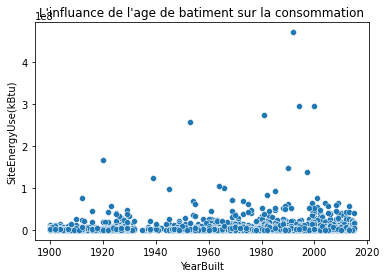

In [74]:
sns.scatterplot(data=df, y="SiteEnergyUse(kBtu)", x="YearBuilt").set_title("L'influance de l'age de batiment sur la consommation")

Text(0.5, 1.0, "L'effet de l'âge du bâtiment sur les émissions de gaz")

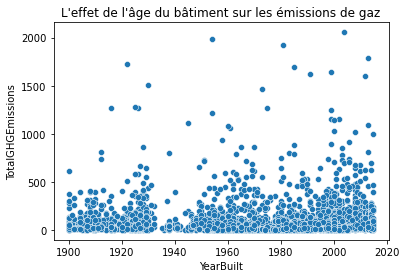

In [75]:
sns.scatterplot(data=df, y="TotalGHGEmissions", x="YearBuilt").set_title("L'effet de l'âge du bâtiment sur les émissions de gaz")

Scatterplot surface / la consommation

Text(0.5, 1.0, "L'effet de la surface sur les émissions de gaz")

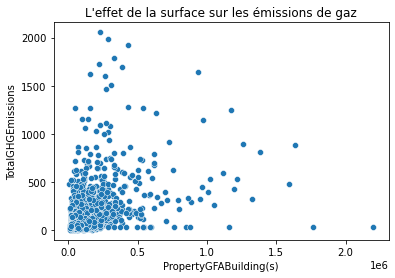

In [78]:
sns.scatterplot(data=df, y="TotalGHGEmissions", x="PropertyGFABuilding(s)").set_title("L'effet de la surface sur les émissions de gaz")

Text(0.5, 1.0, "L'effet de la surface sur la consommation")

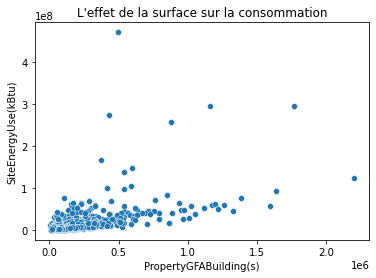

In [77]:
sns.scatterplot(data=df, y="SiteEnergyUse(kBtu)", x="PropertyGFABuilding(s)").set_title("L'effet de la surface sur la consommation")

Boxplot groupé par type de bâtiment de la variable cible

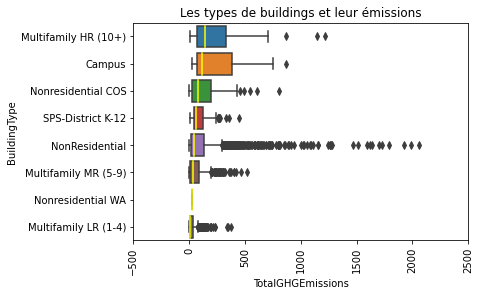

In [81]:

order = df.groupby(by=["BuildingType"])["TotalGHGEmissions"].median().sort_values(ascending=False).index
sns.boxplot(y="BuildingType", x="TotalGHGEmissions", data=df,order=order,medianprops=dict(color="yellow", label='median')).set_title("Les types de buildings et leur émissions");
plt.xticks(plt.xticks()[0], rotation=90);

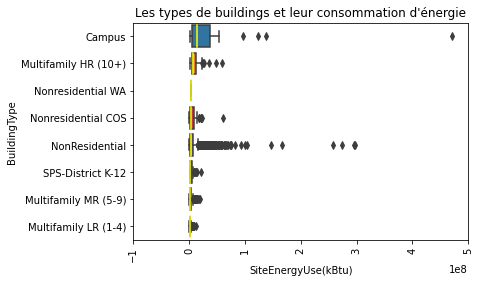

In [82]:
order = df.groupby(by=["BuildingType"])["SiteEnergyUse(kBtu)"].median().sort_values(ascending=False).index
sns.boxplot(y="BuildingType", x="SiteEnergyUse(kBtu)", data=df,order=order,medianprops=dict(color="yellow", label='median')).set_title("Les types de buildings et leur consommation d'énergie");
plt.xticks(plt.xticks()[0], rotation=90);

 répartition des types de bâtiments

Text(0.5, 1.0, 'Répartition des types de bâtiments')

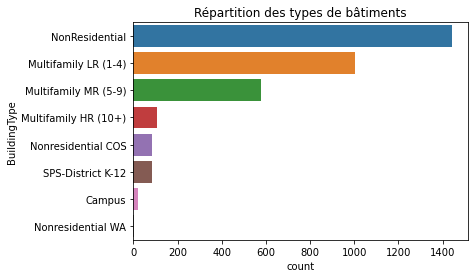

In [83]:
order= df.BuildingType.value_counts().index
sns.countplot(y='BuildingType', data=df,order=order);
plt.title('Répartition des types de bâtiments')

Boxplot groupé par quartier de la variable cible


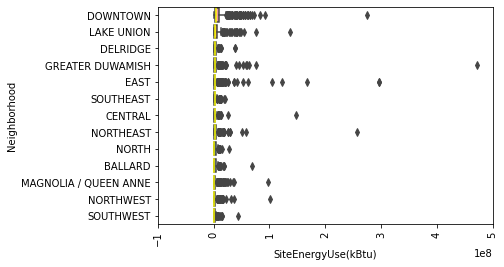

In [84]:
order = df.groupby(by=["Neighborhood"])["SiteEnergyUse(kBtu)"].median().sort_values(ascending=False).index
sns.boxplot(y="Neighborhood", x="SiteEnergyUse(kBtu)", data=df,order=order,medianprops=dict(color="yellow", label='median'))
plt.xticks(plt.xticks()[0], rotation=90);

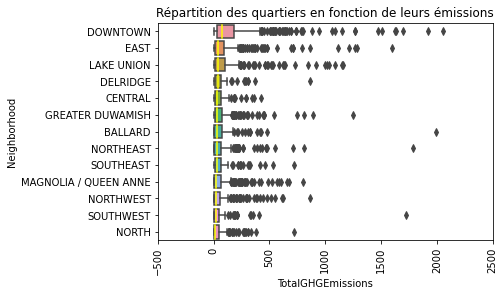

In [85]:
order = df.groupby(by=["Neighborhood"])["TotalGHGEmissions"].median().sort_values(ascending=False).index
sns.boxplot(y="Neighborhood", x="TotalGHGEmissions", data=df,order=order,medianprops=dict(color="yellow", label='median')).set_title("Répartition des quartiers en fonction de leurs émissions")
plt.xticks(plt.xticks()[0], rotation=90);

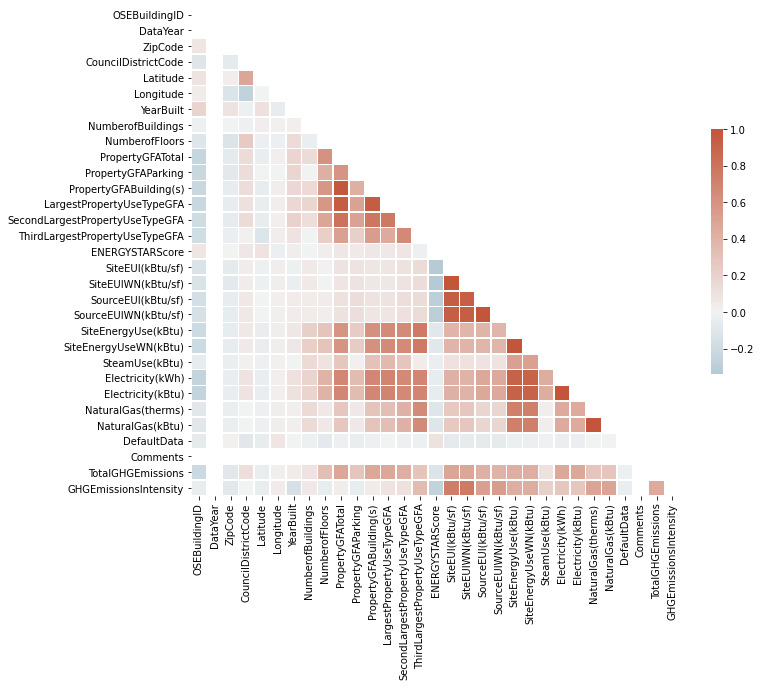

In [86]:
corr = df[numeric_col].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

forte correlation entre: 

    - PropertyGFATotal et (PropertyGFABuilding(s), LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA
    - SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) et SourceEUI(kBtu/sf) et SourceEUIWN(kBtu/sf) 
    - SiteEnergyUse(kBtu) et SiteEnergyUseWN(kBtu) et  Electricity(kWh) et Electricity(kBtu)
    - NaturalGas(therms) et NaturalGas(kBtu)

In [87]:
var_to_predict

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

les informations énergétiques sur le bâtiment

- YearsENERGYSTARCertified:  Année de certification ENERGY STAR

- SiteEUI(kBtu/sf):  Consommation d'énergie : Quantité annuelle d'énergie consommée par le site

- SiteEUIWN(kBtu/sf): Quantité d’énergie que le bien immobilier aurait consommée dans des conditions météorologiques moyennes sur 30 ans.
- SourceEUI(kBtu/sf):  La quantité d’énergie annuelle utilisée pour l'exploitation du bien, y compris les pertes dues à la production, au transport et à la distribution.
- SourceEUIWN(kBtu/sf): Quantité d'énergie de la source que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans.
- Electricity(kWh):  Quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes renouvelables sur place
- NaturalGas(therms): Quantité annuelle de gaz naturel consommée par le bien, mesurée en thermes
- SiteEnergyUseWN(kBtu) = La quantité annuelle d'énergie consommée par le bien, toutes sources d'énergie confondues, ajustée à ce que le bien aurait consommé dans des conditions météorologiques moyennes sur 30 ans.

on selectionne les variables utils pour la prédictions des deux variables: 

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3325 non-null   int64  
 1   DataYear                         3325 non-null   int64  
 2   BuildingType                     3325 non-null   object 
 3   PrimaryPropertyType              3325 non-null   object 
 4   PropertyName                     3325 non-null   object 
 5   Address                          3325 non-null   object 
 6   City                             3325 non-null   object 
 7   State                            3325 non-null   object 
 8   ZipCode                          3309 non-null   float64
 9   TaxParcelIdentificationNumber    3325 non-null   object 
 10  CouncilDistrictCode              3325 non-null   int64  
 11  Neighborhood                     3325 non-null   object 
 12  Latitude            

In [89]:
df['BuildingType'].unique()


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [90]:
df['BuildingType'].value_counts()

NonResidential          1443
Multifamily LR (1-4)    1004
Multifamily MR (5-9)     578
Multifamily HR (10+)     109
Nonresidential COS        84
SPS-District K-12         83
Campus                    23
Nonresidential WA          1
Name: BuildingType, dtype: int64

Il est précisié dans le projet que seuls les bâtiments non destinés à l'habitation seront étudiés. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable BuildingType.



In [91]:
df = df[~df['BuildingType'].str.contains("Multifamily")]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [92]:
df.shape

(1634, 46)

In [93]:
df['NumberofBuildings'].describe()

count   1632.00000
mean       1.10233
std        1.16718
min        0.00000
25%        1.00000
50%        1.00000
75%        1.00000
max       27.00000
Name: NumberofBuildings, dtype: float64

In [94]:
# Bâtiments sans bâtiments
df[df['NumberofBuildings'] == 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
63,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,Seattle,WA,98122.00000,1978201270,...,2897562.75000,9886484.00000,68145.70313,6814570.00000,False,nan,Compliant,NaN,430.84000,2.41000
76,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,Seattle,WA,98109.00000,1988200705,...,1221074.25000,4166305.00000,0.00000,0.00000,False,nan,Compliant,NaN,29.04000,0.44000
160,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,Seattle,WA,98134.00000,7666703020,...,706741.50000,2411402.00000,0.00000,0.00000,False,nan,Compliant,NaN,16.81000,0.21000
201,322,2016,NonResidential,Large Office,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,Seattle,WA,98121.00000,0656000005,...,2868908.50000,9788716.00000,0.00000,0.00000,False,nan,Compliant,NaN,68.24000,0.68000
241,366,2016,NonResidential,Small- and Mid-Sized Office,University District Office Buiding,1107 NE 45th St,Seattle,WA,98105.00000,1142000500,...,839159.31250,2863212.00000,18652.76563,1865277.00000,False,nan,Compliant,NaN,119.03000,1.20000
264,391,2016,NonResidential,Mixed Use Property,Thaw Building,8300 Military Rd South,Seattle,WA,98108.00000,0007400015,...,741693.37500,2530658.00000,18524.42188,1852442.00000,False,nan,Compliant,NaN,116.03000,1.31000
278,408,2016,NonResidential,Large Office,Fourth and Pike Building,1424 4th Ave,Seattle,WA,98101.00000,1975700235,...,1670053.12500,5698221.00000,25.51000,2551.00000,False,nan,Compliant,NaN,65.20000,0.49000
280,410,2016,NonResidential,Hotel,Motif Seattle,1414 4th Ave,Seattle,WA,98101.00000,1975700255,...,5803207.00000,19800542.00000,23989.94922,2398995.00000,False,nan,Compliant,NaN,1468.50000,4.42000
291,421,2016,NonResidential,Other,Meridian (East),1501 7th Ave,Seattle,WA,98101.00000,1976700055,...,1515211.50000,5169902.00000,21032.53125,2103253.00000,False,nan,Compliant,NaN,147.75000,0.55000
358,504,2016,Nonresidential COS,Other,Westbridge,4209 W Marginal Way SW,Seattle,WA,98118.00000,1824049020,...,431091.68750,1470885.00000,21036.57031,2103657.00000,False,nan,Compliant,NaN,121.98000,1.07000


au min 1 builing

In [95]:
df['NumberofBuildings'] = np.where((df.NumberofBuildings == 0), 1,df.NumberofBuildings)

In [96]:
df['NumberofFloors'].value_counts()

1     454
2     382
3     261
4     145
5     102
6      82
7      33
8      22
11     18
10     18
0      15
14      9
12      9
9       8
13      7
15      6
42      5
19      5
17      4
21      3
16      3
18      3
20      3
22      3
24      3
25      3
29      3
33      3
23      3
36      2
34      2
41      2
46      1
63      1
56      1
55      1
49      1
47      1
76      1
39      1
37      1
30      1
28      1
27      1
99      1
Name: NumberofFloors, dtype: int64

In [97]:
df[df['NumberofFloors'] == 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
166,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,Seattle,WA,98101.00000,6792120000,...,11536962.00000,39364114.00000,256831.62500,25683162.00000,False,nan,Compliant,NaN,1638.46000,1.75000
487,656,2016,NonResidential,Medical Office,Arnold Pavilion,1221 Madison Street,Seattle,WA,98104.00000,8725990000,...,3735333.25000,12744957.00000,0.00000,0.00000,False,nan,Compliant,NaN,692.12000,3.06000
488,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,2200 Westlake Ave.,Seattle,WA,98121.00000,8729740000,...,8626261.00000,29432803.00000,99705.11719,9970512.00000,False,nan,Compliant,NaN,734.72000,1.42000
564,758,2016,NonResidential,Other,Pacific Place,600 Pine Street,Seattle,WA,98101.00000,6600470000,...,13631581.00000,46510954.00000,0.00000,0.00000,False,nan,Compliant,NaN,324.25000,0.34000
1754,23311,2016,NonResidential,Medical Office,HART First Hill LLC,1124 Columbia Street,Seattle,WA,98104.00000,8590900646,...,3521475.75000,12015275.00000,0.00000,0.00000,False,nan,Compliant,NaN,1110.07000,4.04000
1993,24086,2016,Campus,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,1333 AIRPORT WAY S,Seattle,WA,98134.00000,7666203387,...,4519276.00000,15419770.00000,56025.15234,5602515.00000,False,nan,Compliant,NaN,405.05000,1.75000
3130,40028,2016,NonResidential,Warehouse,Sandpoint #5,7561 63rd Ave NE,Seattle,WA,98115.00000,0225049077,...,2642108.00000,9014872.00000,61918.87891,6191888.00000,False,nan,Compliant,NaN,391.70000,1.02000
3131,40031,2016,NonResidential,Medical Office,Sandpoint #25,6222 NE 74th St,Seattle,WA,98115.00000,0225049077,...,532064.68750,1815405.00000,3777.10034,377710.00000,False,nan,Compliant,NaN,32.72000,1.08000
3132,40034,2016,NonResidential,Small- and Mid-Sized Office,Sandpoint #29,6200 NE 74th ST,Seattle,WA,98115.00000,0225049077,...,409903.50000,1398591.00000,25486.18555,2548619.00000,False,nan,Compliant,NaN,145.11000,6.62000
3168,49705,2016,Nonresidential COS,Other,Magnuson,7400 Sand Point Way NE,Seattle,WA,98115.00000,0225049062,...,2743225.00000,9359884.00000,91104.54688,9110455.00000,False,nan,Compliant,NaN,549.11000,1.09000


In [98]:
median = df['NumberofFloors'].median()
df['NumberofFloors'].replace(0, 1, inplace=True)


In [99]:
df['NumberofFloors'].value_counts()

1     469
2     382
3     261
4     145
5     102
6      82
7      33
8      22
11     18
10     18
12      9
14      9
9       8
13      7
15      6
42      5
19      5
17      4
21      3
16      3
18      3
20      3
22      3
24      3
25      3
29      3
33      3
23      3
36      2
34      2
41      2
46      1
63      1
56      1
55      1
49      1
47      1
76      1
39      1
37      1
30      1
28      1
27      1
99      1
Name: NumberofFloors, dtype: int64

# Feature Engineering

In [100]:
var_to_predict

['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

les informations énergétiques sur le bâtiment

- YearsENERGYSTARCertified:  Année de certification ENERGY STAR

- SiteEUI(kBtu/sf):  Consommation d'énergie : Quantité annuelle d'énergie consommée par le site

- SiteEUIWN(kBtu/sf): Quantité d’énergie que le bien immobilier aurait consommée dans des conditions météorologiques moyennes sur 30 ans.
- SourceEUI(kBtu/sf):  La quantité d’énergie annuelle utilisée pour l'exploitation du bien, y compris les pertes dues à la production, au transport et à la distribution.
- SourceEUIWN(kBtu/sf): Quantité d'énergie de la source que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans.
- Electricity(kWh):  Quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée au réseau et produite par des systèmes renouvelables sur place
- NaturalGas(therms): Quantité annuelle de gaz naturel consommée par le bien, mesurée en thermes
- SiteEnergyUseWN(kBtu) = La quantité annuelle d'énergie consommée par le bien, toutes sources d'énergie confondues, ajustée à ce que le bien aurait consommé dans des conditions météorologiques moyennes sur 30 ans.

on selectionne les variables utils pour la prédictions des deux variables: 

In [101]:
var_to_remove=['OSEBuildingID','ZipCode','DataYear','PropertyName','TaxParcelIdentificationNumber','City','Comments','State',
               'YearsENERGYSTARCertified','Address', 'Outlier', 'DefaultData',
               'LargestPropertyUseTypeGFA', 'CouncilDistrictCode',
               'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA',
               'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
               'Electricity(kWh)', 'NaturalGas(therms)','SiteEnergyUseWN(kBtu)',
               'GHGEmissionsIntensity','Longitude','Latitude','ListOfAllPropertyUseTypes','SteamUse(kBtu)','NaturalGas(kBtu)'
              ]

In [102]:
df_data = df.drop(var_to_remove, axis=1)

In [103]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 0 to 3375
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1634 non-null   object 
 1   PrimaryPropertyType           1634 non-null   object 
 2   Neighborhood                  1634 non-null   object 
 3   YearBuilt                     1634 non-null   int64  
 4   NumberofBuildings             1632 non-null   float64
 5   NumberofFloors                1634 non-null   int64  
 6   PropertyGFATotal              1634 non-null   int64  
 7   PropertyGFAParking            1634 non-null   int64  
 8   PropertyGFABuilding(s)        1634 non-null   int64  
 9   LargestPropertyUseType        1634 non-null   object 
 10  SecondLargestPropertyUseType  1634 non-null   object 
 11  ThirdLargestPropertyUseType   351 non-null    object 
 12  ENERGYSTARScore               1082 non-null   float64
 13  Sit

description des variables qui reste:

- BuildingType = Classification des types de la propriété
- CouncilDistrictCode = Code du conseil municipal de la ville 
- Neighborhood = Quartier de la propriété
- Latitude = latitude du bâtiment
- Longitude = longitude du bâtiment
- NumberofBuildings = Nombre de bâtiments inclus dans la propriété (cf campus composé de plusieurs bâtiments)
- NumberofFloors = Nombre d'étages de la propriété
- PropertyGFATotal = Surface brute totale du bâtiment et du parking.
- PropertyGFAParking = Surface totale de tous les parkings 
- PropertyGFABuilding(s) = Surface totale du bâtiment.
- ListOfAllPropertyUseTypes = Liste des utilisations des biens immobiliers
- ENERGYSTARScore = Performance énergétique globale d'une propriété
- SiteEnergyUse(kBtu) = La quantité annuelle d'énergie consommée par le bien, toutes sources d'énergie confondues.
- SteamUse(kBtu) = Quantité annuelle de vapeur consommée par le bâtiment
- Electricity(kBtu) = Quantité annuelle d'électricité consommée par la propriété, y compris l'électricité achetée au réseau et produite par des systèmes renouvelables sur place.
- NaturalGas(kBtu) = Quantité annuelle de gaz naturel consommée par le bien en milliers d'unités thermiques britanniques (kBtu).
- ComplianceStatus = Si un bien immobilier a satisfait aux exigences en matière d'analyse comparative de la consommation d'énergie pour l'année en cours.
- TotalGHGEmissions = Quantité totale d'émissions de gaz à effet de serre rejetée dans l'atmosphère à la suite de la consommation d'énergie sur le site, mesurée en tonnes d'équivalent dioxyde de carbone.
- GHGEmissionsIntensity = Total des émissions de gaz à effet de serre divisé par la surface brute de la propriété, mesurée en kilogrammes d'équivalent dioxyde de carbone par pied carré.







In [104]:
df_data.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),TotalGHGEmissions
count,1634.00000,1632.00000,1634.00000,1634.00000,1634.00000,1634.00000,1082.00000,1634.00000,1632.00000,1634.00000
mean,1962.05875,1.13419,4.16769,113479.03121,13124.48531,100354.54590,65.15896,8061797.73079,5512311.42836,128.51930
std,32.68529,1.15016,6.61735,193109.72675,42666.04920,171293.62289,28.36984,22202501.08041,13410608.47207,221.14778
min,1900.00000,1.00000,1.00000,11285.00000,0.00000,3636.00000,1.00000,57133.19922,-115417.00000,0.86000
25%,1930.00000,1.00000,1.00000,29395.50000,0.00000,28375.25000,48.00000,1268686.12500,740801.00000,21.39250
50%,1966.00000,1.00000,2.00000,49246.00000,0.00000,47226.00000,73.00000,2615610.62500,1639912.00000,49.26500
75%,1989.00000,1.00000,4.00000,105090.25000,0.00000,94853.25000,89.00000,6963230.62500,4919991.25000,134.52250
max,2015.00000,27.00000,99.00000,2200000.00000,512608.00000,2200000.00000,100.00000,471613856.00000,274532495.00000,2055.82000


Créer une nouvelle variable du volume du bâtiment 

In [105]:
values = df_data['PropertyGFABuilding(s)'] * df_data.NumberofFloors
df_data['VolumBuilding'] = values

In [106]:
df_data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),ComplianceStatus,TotalGHGEmissions,VolumBuilding
0,NonResidential,Hotel,DOWNTOWN,1927,1.00000,12,88434,0,88434,Hotel,Missing,NaN,60.00000,7226362.50000,3946027.00000,Compliant,249.98000,1061208
1,NonResidential,Hotel,DOWNTOWN,1996,1.00000,11,103566,15064,88502,Hotel,Parking,Restaurant,61.00000,8387933.00000,3242851.00000,Compliant,295.86000,973522
2,NonResidential,Hotel,DOWNTOWN,1969,1.00000,41,956110,196718,759392,Hotel,Missing,NaN,43.00000,72587024.00000,49526664.00000,Compliant,34.11000,31135072
3,NonResidential,Hotel,DOWNTOWN,1926,1.00000,10,61320,0,61320,Hotel,Missing,NaN,56.00000,6794584.00000,2768924.00000,Compliant,286.43000,613200
4,NonResidential,Hotel,DOWNTOWN,1980,1.00000,18,175580,62000,113580,Hotel,Parking,Swimming Pool,75.00000,14172606.00000,5368607.00000,Compliant,505.01000,2044440


ratio surface batiment par rapport surface parking

In [107]:
values = df_data['PropertyGFABuilding(s)'].divide(df_data.PropertyGFAParking )

In [108]:
df_data['RatioBuildingParking'] = values

In [109]:
df_data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),ComplianceStatus,TotalGHGEmissions,VolumBuilding,RatioBuildingParking
0,NonResidential,Hotel,DOWNTOWN,1927,1.00000,12,88434,0,88434,Hotel,Missing,NaN,60.00000,7226362.50000,3946027.00000,Compliant,249.98000,1061208,inf
1,NonResidential,Hotel,DOWNTOWN,1996,1.00000,11,103566,15064,88502,Hotel,Parking,Restaurant,61.00000,8387933.00000,3242851.00000,Compliant,295.86000,973522,5.87507
2,NonResidential,Hotel,DOWNTOWN,1969,1.00000,41,956110,196718,759392,Hotel,Missing,NaN,43.00000,72587024.00000,49526664.00000,Compliant,34.11000,31135072,3.86031
3,NonResidential,Hotel,DOWNTOWN,1926,1.00000,10,61320,0,61320,Hotel,Missing,NaN,56.00000,6794584.00000,2768924.00000,Compliant,286.43000,613200,inf
4,NonResidential,Hotel,DOWNTOWN,1980,1.00000,18,175580,62000,113580,Hotel,Parking,Swimming Pool,75.00000,14172606.00000,5368607.00000,Compliant,505.01000,2044440,1.83194


In [110]:
df_data['RatioBuildingParking'].replace(np.inf, 0, inplace=True)

In [111]:
df_data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity(kBtu),ComplianceStatus,TotalGHGEmissions,VolumBuilding,RatioBuildingParking
0,NonResidential,Hotel,DOWNTOWN,1927,1.00000,12,88434,0,88434,Hotel,Missing,NaN,60.00000,7226362.50000,3946027.00000,Compliant,249.98000,1061208,0.00000
1,NonResidential,Hotel,DOWNTOWN,1996,1.00000,11,103566,15064,88502,Hotel,Parking,Restaurant,61.00000,8387933.00000,3242851.00000,Compliant,295.86000,973522,5.87507
2,NonResidential,Hotel,DOWNTOWN,1969,1.00000,41,956110,196718,759392,Hotel,Missing,NaN,43.00000,72587024.00000,49526664.00000,Compliant,34.11000,31135072,3.86031
3,NonResidential,Hotel,DOWNTOWN,1926,1.00000,10,61320,0,61320,Hotel,Missing,NaN,56.00000,6794584.00000,2768924.00000,Compliant,286.43000,613200,0.00000
4,NonResidential,Hotel,DOWNTOWN,1980,1.00000,18,175580,62000,113580,Hotel,Parking,Swimming Pool,75.00000,14172606.00000,5368607.00000,Compliant,505.01000,2044440,1.83194


In [112]:
df_data = df_data.drop('PropertyGFATotal', axis=1)

In [113]:
def energy_indicator(row):
    if row['Electricity(kBtu)'] > 0 :
        val =1
    else:
        val = 0
    return val

In [114]:
df_data['EnergyIndicator'] = df_data.apply(energy_indicator, axis=1)

In [115]:
df_data = df_data.drop('Electricity(kBtu)', axis=1)

In [116]:
df_data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),ComplianceStatus,TotalGHGEmissions,VolumBuilding,RatioBuildingParking,EnergyIndicator
0,NonResidential,Hotel,DOWNTOWN,1927,1.00000,12,0,88434,Hotel,Missing,NaN,60.00000,7226362.50000,Compliant,249.98000,1061208,0.00000,1
1,NonResidential,Hotel,DOWNTOWN,1996,1.00000,11,15064,88502,Hotel,Parking,Restaurant,61.00000,8387933.00000,Compliant,295.86000,973522,5.87507,1
2,NonResidential,Hotel,DOWNTOWN,1969,1.00000,41,196718,759392,Hotel,Missing,NaN,43.00000,72587024.00000,Compliant,34.11000,31135072,3.86031,1
3,NonResidential,Hotel,DOWNTOWN,1926,1.00000,10,0,61320,Hotel,Missing,NaN,56.00000,6794584.00000,Compliant,286.43000,613200,0.00000,1
4,NonResidential,Hotel,DOWNTOWN,1980,1.00000,18,62000,113580,Hotel,Parking,Swimming Pool,75.00000,14172606.00000,Compliant,505.01000,2044440,1.83194,1


In [117]:
df_data.shape

(1634, 18)

Création d'une variable pour le nombre total d'usages du bâtiment

In [118]:
#df_data['ListOfAllPropertyUseTypes'].value_counts()

In [119]:
'''from collections import Counter
list_types = []
for word in df_data['ListOfAllPropertyUseTypes'].str.split(',| |/|\(|\)'):
    for w in word :
        if w != '' and w != '-' and w != '&' and w != 'and' and w != 'etc':
            list_types.append(w.strip().lower())
Counter(list_types)'''

"from collections import Counter\nlist_types = []\nfor word in df_data['ListOfAllPropertyUseTypes'].str.split(',| |/|\\(|\\)'):\n    for w in word :\n        if w != '' and w != '-' and w != '&' and w != 'and' and w != 'etc':\n            list_types.append(w.strip().lower())\nCounter(list_types)"

In [120]:
#df_data['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in df_data['ListOfAllPropertyUseTypes'].str.split(',')]

In [121]:
#df_data['TotalUseTypeNumber'].value_counts()

In [122]:
#df_data.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

In [123]:
typeDict = {
    #Education
    

    'K-12 School' : 'Education',
    'University'  : 'Education',
    'Other - Education': 'Education',
    'Adult Education': 'Education',
    'College/University': 'Education',
    'Pre-school/Daycare': 'Education',
    'Vocational School': 'Education',
   
    #loisir
    'Fitness Center/Health Club/Gym' : 'Entertainment',
    'Other - Entertainment/Public Assembly' :  'Entertainment',
    'Swimming Pool': 'Entertainment',
    'Movie Theater' : 'Entertainment',
    'Bar/Nightclub': 'Entertainment',
    'Performing Arts': 'Entertainment',
    'Social/Meeting Hall' : 'Entertainment',
    'Museum' : 'Entertainment',
    'Lifestyle Center': 'Entertainment',
    'Convention Center': 'Entertainment',
    
    
    #Food
    

    'Distribution Center' : 'Food',
    'Supermarket / Grocery Store':'Food',
    'Restaurant': 'Food',
    'Supermarket/Grocery Store': 'Food',
    'Food Sales' : 'Food',
    'ther - Restaurant/Bar' : 'Food',
    'Food Service': 'Food',
    'Other - Restaurant/Bar': 'Food',
    'Fast Food Restaurant': 'Food',
    #Healthcare

    
    'Medical Office': 'Healthcare',
    'Hospital': 'Healthcare',
    'Laboratory': 'Healthcare',
    'Hospital (General Medical & Surgical)' : 'Healthcare',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Healthcare',
    'Other/Specialty Hospital': 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient': 'Healthcare',

    #Lodging


    'Mixed Use Property': 'Lodging',
    'Hotel': 'Lodging',
    'Residence Hall': 'Lodging',
    'Low-Rise Multifamily': 'Lodging',
    'Multifamily Housing' : 'Lodging',
    'Residence Hall/Dormitory': 'Lodging',
    'Other - Lodging/Residential' : 'Lodging',
    'Prison/Incarceration': 'Lodging',
    'Residential Care Facility': 'Lodging',
        
    #Manufacturing/Warehouse

    
    'Warehouse': 'Industrial',
    'Self-Storage Facility': 'Industrial',
    'Refrigerated Warehouse': 'Industrial',
    'Non-Refrigerated Warehouse' : 'Industrial',
    'Manufacturing/Industrial Plant' : 'Industrial',
    'Convenience Store without Gas Station': 'Industrial',
    #Office


    'Small- and Mid-Sized Office' : 'Office',
    'Large Office' : 'Office',
    'Office': 'Office',
    'Data Center' : 'Office',
    'Bank Branch' : 'Office',
    'Financial Office' :  'Office',
    'Other - Technology/Science':  'Office',
    
    #Public Services


    'Worship Facility':'PublicService',
    'Senior Care Community': 'PublicService',
    'Other - Public Services' : 'PublicService',
    'Courthouse': 'PublicService',
    'Library': 'PublicService',
    'Fire Station': 'PublicService',
    'Police Station': 'PublicService',
    'PublicService': 'PublicService',
    
    
    #Retail


    'Retail Store': 'Retail',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
    'Automobile Dealership' : 'Retail',
    'Enclosed Mall' :   'Retail',
    'Strip Mall' : 'Retail',
    'Other - Mall': 'Retail',
    'Wholesale Club/Supercenter': 'Retail',
    
    #Other

    
    'Other': 'Other',
    'Parking':'Other',
    'Other - Services'  :'Other',
    'Other - Recreation' : 'Other',
    'Other - Utility': 'Other',
    
    #Missing information 
    'missinginfo' : 'Missing'

}

In [124]:
propertyTypes_columns = ['PrimaryPropertyType', 'SecondLargestPropertyUseType','LargestPropertyUseType']

In [125]:
df_data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    289
Other                          245
Warehouse                      187
Large Office                   170
K-12 School                    123
Mixed Use Property             114
Retail Store                    89
Hotel                           75
Worship Facility                69
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

In [126]:
df_data['PrimaryPropertyType'] = df_data['PrimaryPropertyType'].replace(typeDict, regex=False)

In [127]:
df_data['PrimaryPropertyType'].value_counts()

Office           462
Other            245
Industrial       227
Lodging          212
Education        146
Food             105
PublicService     89
Retail            89
Healthcare        59
Name: PrimaryPropertyType, dtype: int64

In [128]:
df_data['SecondLargestPropertyUseType'].value_counts()

Missing                                                 787
Parking                                                 332
Office                                                  167
Retail Store                                             85
Other                                                    44
Restaurant                                               29
Non-Refrigerated Warehouse                               29
Fitness Center/Health Club/Gym                           16
Data Center                                              12
Multifamily Housing                                      12
Other - Services                                         11
Supermarket/Grocery Store                                10
Medical Office                                            8
Laboratory                                                8
Distribution Center                                       7
Other - Entertainment/Public Assembly                     7
Bank Branch                             

In [129]:
df_data['SecondLargestPropertyUseType'] = df_data['SecondLargestPropertyUseType'].replace(typeDict, regex=False)

In [130]:
df_data['SecondLargestPropertyUseType'].value_counts()

Missing          787
Other            391
Office           187
Retail            92
Food              51
Industrial        37
Entertainment     35
Healthcare        18
Lodging           17
Education         12
PublicService      7
Name: SecondLargestPropertyUseType, dtype: int64

In [131]:
df_data['LargestPropertyUseType'].value_counts()

Office                                                  491
Non-Refrigerated Warehouse                              199
K-12 School                                             123
Retail Store                                             97
Other                                                    95
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       23
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                   

In [132]:
df_data['LargestPropertyUseType'] = df_data['LargestPropertyUseType'].replace(typeDict, regex=False)

In [133]:
df_data['LargestPropertyUseType'].value_counts()

Office           502
Industrial       246
Other            163
Education        153
Retail           119
Lodging          117
Food             110
PublicService     98
Healthcare        73
Entertainment     47
Missing            6
Name: LargestPropertyUseType, dtype: int64

In [134]:
df_data['ThirdLargestPropertyUseType'].value_counts()

Office                                                  49
Retail Store                                            48
Parking                                                 45
Other                                                   39
Restaurant                                              32
Non-Refrigerated Warehouse                              15
Data Center                                             13
Multifamily Housing                                     12
Swimming Pool                                           10
Medical Office                                           9
Pre-school/Daycare                                       8
Food Service                                             8
Social/Meeting Hall                                      8
Bank Branch                                              5
Other - Restaurant/Bar                                   5
Financial Office                                         4
Fitness Center/Health Club/Gym                          

In [135]:
df_data['ThirdLargestPropertyUseType'] = df_data['ThirdLargestPropertyUseType'].replace(typeDict, regex=False)

In [136]:
df_data['ThirdLargestPropertyUseType'].value_counts()

Other            89
Office           73
Food             50
Retail           49
Entertainment    27
Industrial       22
Healthcare       14
Education        13
Lodging          13
PublicService     1
Name: ThirdLargestPropertyUseType, dtype: int64

# Préparation du DataSet pour la modélisation

In [137]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 0 to 3375
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BuildingType                  1634 non-null   object 
 1   PrimaryPropertyType           1634 non-null   object 
 2   Neighborhood                  1634 non-null   object 
 3   YearBuilt                     1634 non-null   int64  
 4   NumberofBuildings             1632 non-null   float64
 5   NumberofFloors                1634 non-null   int64  
 6   PropertyGFAParking            1634 non-null   int64  
 7   PropertyGFABuilding(s)        1634 non-null   int64  
 8   LargestPropertyUseType        1634 non-null   object 
 9   SecondLargestPropertyUseType  1634 non-null   object 
 10  ThirdLargestPropertyUseType   351 non-null    object 
 11  ENERGYSTARScore               1082 non-null   float64
 12  SiteEnergyUse(kBtu)           1634 non-null   float64
 13  Com

In [138]:
df_data.describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,VolumBuilding,RatioBuildingParking,EnergyIndicator
count,1634.00000,1632.00000,1634.00000,1634.00000,1634.00000,1082.00000,1634.00000,1634.00000,1634.00000,1634.00000,1634.00000
mean,1962.05875,1.13419,4.16769,13124.48531,100354.54590,65.15896,8061797.73079,128.51930,1105989.48960,0.71724,0.99694
std,32.68529,1.15016,6.61735,42666.04920,171293.62289,28.36984,22202501.08041,221.14778,5800210.38124,2.48210,0.05525
min,1900.00000,1.00000,1.00000,0.00000,3636.00000,1.00000,57133.19922,0.86000,7272.00000,0.00000,0.00000
25%,1930.00000,1.00000,1.00000,0.00000,28375.25000,48.00000,1268686.12500,21.39250,48320.50000,0.00000,1.00000
50%,1966.00000,1.00000,2.00000,0.00000,47226.00000,73.00000,2615610.62500,49.26500,105104.00000,0.00000,1.00000
75%,1989.00000,1.00000,4.00000,0.00000,94853.25000,89.00000,6963230.62500,134.52250,340902.00000,0.00000,1.00000
max,2015.00000,27.00000,99.00000,512608.00000,2200000.00000,100.00000,471613856.00000,2055.82000,124094320.00000,64.43894,1.00000


In [139]:
df_data.isna().mean()

BuildingType                   0.00000
PrimaryPropertyType            0.00000
Neighborhood                   0.00000
YearBuilt                      0.00000
NumberofBuildings              0.00122
NumberofFloors                 0.00000
PropertyGFAParking             0.00000
PropertyGFABuilding(s)         0.00000
LargestPropertyUseType         0.00000
SecondLargestPropertyUseType   0.00000
ThirdLargestPropertyUseType    0.78519
ENERGYSTARScore                0.33782
SiteEnergyUse(kBtu)            0.00000
ComplianceStatus               0.00000
TotalGHGEmissions              0.00000
VolumBuilding                  0.00000
RatioBuildingParking           0.00000
EnergyIndicator                0.00000
dtype: float64

In [140]:
df_data.ThirdLargestPropertyUseType.fillna('Missing',inplace=True)

In [141]:
medianNumberofBuildings = df_data['NumberofBuildings'].median()
# Remplacer les valeurs manquantes par la médiane pour les variables numérique
df_data['NumberofBuildings'] = df_data['NumberofBuildings'].fillna(value = medianNumberofBuildings)

In [142]:
df_data= df_data.reset_index()

In [143]:
df_data.shape

(1634, 19)

In [144]:
df_data = df_data.drop(['index'], axis=1)

In [145]:
df_data.to_feather("cleaned_data.feather")